In [2]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
!pip install geopandas

  Using cached https://files.pythonhosted.org/packages/21/80/da2a33c9201cd4ce693f4aa6189efc9ef1a48bec1c3b02c3ce9908b07fec/geopandas-0.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/9d/63696e7b1de42aad294d4781199a408bec593d8fdb80a2b4a788c911a33b/Fiona-1.8.6.tar.gz


    ERROR: Complete output from command python setup.py egg_info:
    ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in C:\Users\asyel\AppData\Local\Temp\pip-install-cnqmg012\fiona\


In [3]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

In [4]:
shp_path_c = "./geo_export_ed8adefc-d13e-4894-93ef-3e3309ee864d.shp"
shp_path_n = "./Neighborhoods_2012b.shp"
sf_c = shp.Reader(shp_path_c)
sf_n = shp.Reader(shp_path_n)
mod_data = pd.read_csv("./test.csv") 

In [5]:
mod_data.head()

,X,Y,coords,pri_neigh,sec_neigh,shape_area,shape_len
0,-87.617830,41.812936,"(-87.6178303408548,41.8129360483933)",Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837160
1,-87.629042,41.871062,"(-87.6290421412249,41.8710620398849)",Printers Row,PRINTERS ROW,2.162138e+06,6864.247156
2,-87.679520,41.882164,"(-87.6795202233802,41.8821643843664)",United Center,UNITED CENTER,3.252051e+07,23101.363750
3,-87.653670,41.927182,"(-87.6536703007042,41.9271818682355)",Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049750
4,-87.716535,41.900873,"(-87.7165352230197,41.9008731136225)",Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751350


In [5]:
len(sf_c.shapes())

801

In [6]:
len(sf_n.shapes())

98

In [7]:
sf_c.records()[1]

Record #1: ['59', 59.0, '031', '17031840300', '8403', 'Census Tract 8403', '', '17', '840300']

In [8]:
sf_n.records()[1]

Record #1: ['Printers Row', 'PRINTERS ROW', 2162137.97139, 6864.247156]

In [9]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [10]:
df_c = read_shapefile(sf_c)
df_c.shape

(801, 10)

In [11]:
df_n = read_shapefile(sf_n)
df_n.shape

(98, 5)

In [12]:
df_c.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,coords
0,44,44.0,031,17031842400,8424,Census Tract 8424,,17,842400,"[(-87.62404799998049, 41.73021699998396), (-87..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,,17,840300,"[(-87.6860799999848, 41.82295600001154), (-87...."
2,34,34.0,031,17031841100,8411,Census Tract 8411,,17,841100,"[(-87.62934700001182, 41.8527970000265), (-87...."
3,31,31.0,031,17031841200,8412,Census Tract 8412,,17,841200,"[(-87.68813499997718, 41.85569099999095), (-87..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,,17,839000,"[(-87.63312200003458, 41.87448800002695), (-87..."


In [13]:
df_n.head()

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,coords
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"[(1182322.0428999998, 1876674.7307000011), (11..."
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"[(1176452.803199999, 1897600.9275999963), (117..."
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"[(1165664.4825000018, 1902791.8572999984), (11..."
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"[(1167948.4904999994, 1914766.2669999972), (11..."
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"[(1145646.625, 1902270.1251000017), (1145645.0..."


In [7]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (15,15)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

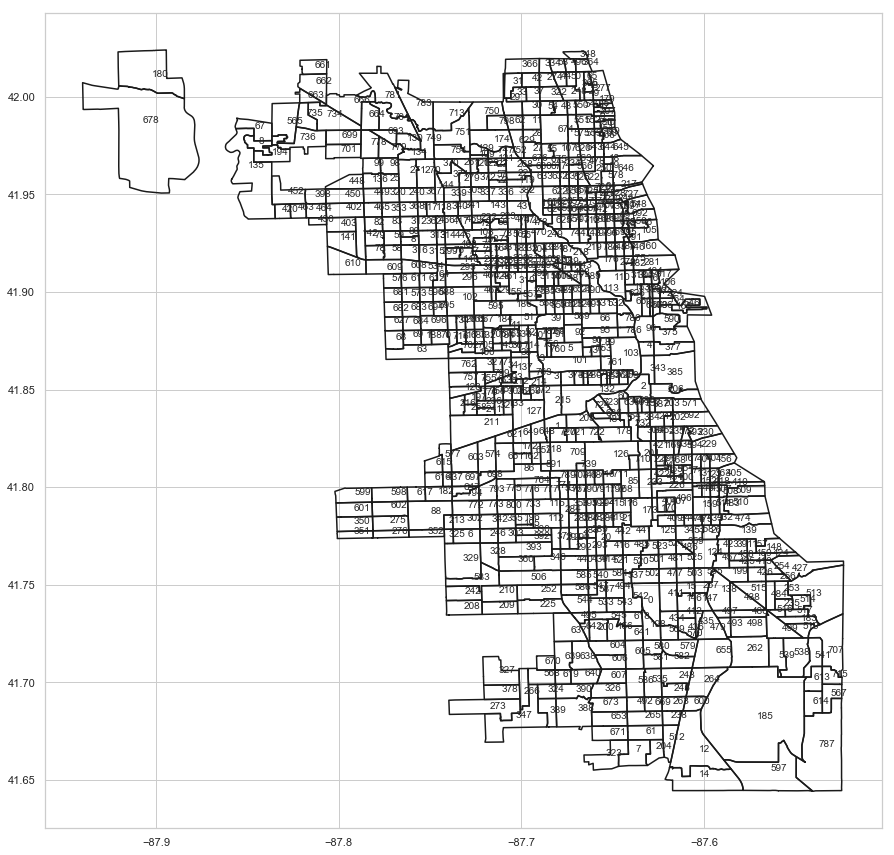

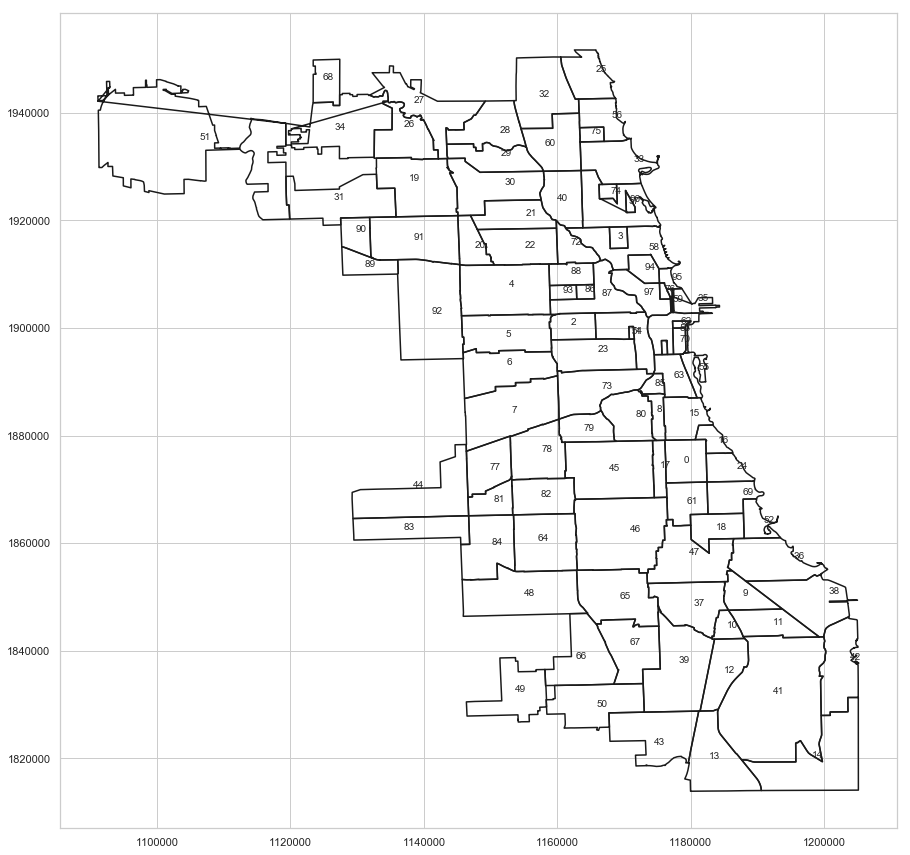

In [14]:
plot_map(sf_c)
plot_map(sf_n)